# Laboratorio de Introducción al Procesamiento de Lenguaje Natural 2016

## Procedimiento para etiquetado manual del corpus

La etapa de etiquetado de corpus es sumamente importante, ya que a partir de estas etiquetas es se va a desarrollar el trabajo. La calidad de los resultados va a depender fuertemente de esta etapa.


Para esta tarea, una herramienta con la que se experimentó fue nltk. En el string de texto crudo se concatena a cada palabra su etiqueta, separados por el caracter ‘/’. Luego con nltk.tag.str2tuple() transforma este string en una lista de tuplas que contienen la palabra y el tag.


In [79]:
import json
from pyfreeling import Analyzer

import inspect
print(inspect.getfile(Analyzer))

import upos_converter as up
import importlib
importlib.reload(up)


import pandas
import random
import nltk
sent = '''
 The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN
 other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC
 Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS
 said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB
 accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT
 interest/NN of/IN both/ABX governments/NNS ''/'' ./.
 Palabra/etiqueta
 '''
[nltk.tag.str2tuple(t) for t in sent.split()]

/home/rodrigo/IPLN_3/lib/python3.5/site-packages/pyfreeling/__init__.py


[('The', 'AT'),
 ('grand', 'JJ'),
 ('jury', 'NN'),
 ('commented', 'VBD'),
 ('on', 'IN'),
 ('a', 'AT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('other', 'AP'),
 ('topics', 'NNS'),
 (',', ','),
 ('AMONG', 'IN'),
 ('them', 'PPO'),
 ('the', 'AT'),
 ('Atlanta', 'NP'),
 ('and', 'CC'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('purchasing', 'VBG'),
 ('departments', 'NNS'),
 ('which', 'WDT'),
 ('it', 'PPS'),
 ('said', 'VBD'),
 ('``', '``'),
 ('ARE', 'BER'),
 ('well', 'QL'),
 ('operated', 'VBN'),
 ('and', 'CC'),
 ('follow', 'VB'),
 ('generally', 'RB'),
 ('accepted', 'VBN'),
 ('practices', 'NNS'),
 ('which', 'WDT'),
 ('inure', 'VB'),
 ('to', 'IN'),
 ('the', 'AT'),
 ('best', 'JJT'),
 ('interest', 'NN'),
 ('of', 'IN'),
 ('both', 'ABX'),
 ('governments', 'NNS'),
 ("''", "''"),
 ('.', '.'),
 ('Palabra', 'ETIQUETA')]

Es de destacar que esta herramienta no toma en cuenta ningún conjunto de etiquetas, por lo que se usan las etiqueta que el usuario defina. Esto se ve claramente en el ultimo token etiquetado como 'ETIQUETA'. Esto la hace muy flexible para diversas tareas que impliquen etiquetado manual.


Dado que el lenguaje natural es ambiguo, se debe contar con más de un anotador de manera que la calidad del trabajo mejore, y se pueda tener una idea de cuantas ambigüedades no resueltas hay en el texto, de manera que se pueda comparar el desempeño de la máquina con el de los humanos.



## Definición de corpus de entrenamiento, testeo, y eventualmente desarrollo.

Evaluar sobre el mismo conjunto en el que se entreno, es similar a estudiar para un examen leyendo lo que nos van a preguntar. El alumno va a tender a memorizar respuestas en vez de aprender, y cuando se enfrente a una situación nueva seguramente no al  sepa resolver.
Lo mismo pasa con tareas de aprendizaje automático: debe separarse la información que se va a utilizar para entrenar de la que se usará para evaluar. Lo ideal es tener bien separadas dos instancias: una para desarrollo y entrenamiento, y otra para la evaluación final. Durante la fase de desarrollo, se realiza la elección y ajuste tanto de parámetros como de características. Para evitar que estas elecciones se sobreajusten al conjunto de entrenamiento, podemos partir este nuevamente en dos: uno para entrenar, y otro para pre evaluar el agente, usando estos resultados para decidir que parámetros modificar. De esta forma, debemos partir el corpus en tres partes: entrenamiento, desarrollo y testeo.


Cómo elegir qué instancias van a parar a cada corpus, es una decisión que se debe tomar con cuidado. Lo más sencillo es partir aleatoriamente el conjunto en tres. El problema es que a diferencia de otros enfoques, como validación cruzada donde se realizan múltiples particiones, únicamente se va a hacer una, por lo que es importante que todos los conjuntos sean representativos de la realidad. A modo de ejemplo, imaginemos que para el reconocimiento de entidades con nombre tenemos muy pocas organizaciones, y van a parar todas al conjunto de testeo, nuestro algoritmo no tendrá como aprender a reconocerlas. Se debe tomar en cuenta además, la tarea que vamos a realizar. 


En este caso, si bien el texto no está etiquetado, contamos con información respecto de su procedencia. Una buena alternativa es separar los tres corpus manteniendo la proporcionalidad respecto de los procedimientos ya que es esperable que procedimientos como “Regulación de honorarios” y “Reconocimiento y ejecución de sentencias extranjeras” manejan vocabularios bien diferentes.


# Importación del corpus

In [80]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline


corpus = pandas.read_csv("corpus_pj.csv", delimiter=',', skip_blank_lines=True, encoding='utf-8')
corpus = corpus.drop_duplicates()
sentencias = corpus["sentencia"]

## Análisis del corpus

En esta sección se presentan datos estadísticos de la realidad en la que se enmarca el corpus. 


In [81]:
print('# total de atributos: %d' % corpus.columns.size) 
print('# total de sentenias: %d' % corpus.index.size)

# total de atributos: 9
# total de sentenias: 20046


In [82]:
corpus.head(3)

,importancia,sentencia,tipo,resumen,numero,sede,procedimiento,fecha,ficha
0,ALTA,"Montevideo, tres de setiembre de dos mil siete...",DEFINITIVA,El recurrente plantea que el Tribunal vulneró ...,147/2007,Suprema Corte de Justicia,RECURSO DE CASACIÓN,03/09/2007,343-291/2004
1,ALTA,"Sentencia Nro.247/08i.-,Tribunal de Apelacione...",INTERLOCUTORIA,NaN,247/2008,Tribunal Apelaciones Civil 3ºTº,PROCESO CIVIL ORDINARIO,10/11/2008,2-45365/2007
2,ALTA,TRIBUNAL DE APELACIONES EN LO CIVIL DE 1º TURN...,INTERLOCUTORIA,NaN,190/2007,Tribunal Apelaciones Civil 1ºTº,PROCESO CIVIL ORDINARIO,22/08/2007,2-14957/2006


fecha
1      686
2     1782
3     2109
4     2109
5     1958
6     1886
7     1781
8     1608
9     1592
10    1622
11    1586
12    1327
dtype: int64


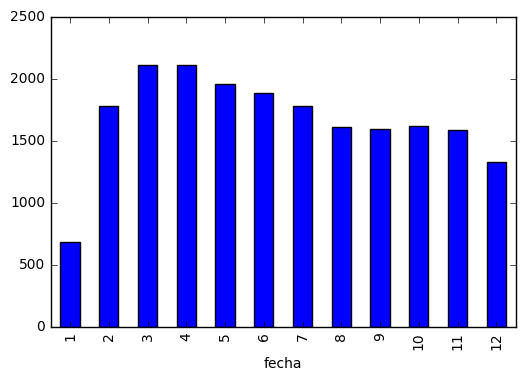

In [83]:
ci = pandas.to_datetime(corpus.fecha)
month = ci.groupby(ci.map(lambda x: x.month)).size()
print(month)
month.plot(kind='bar');

En esta gráfica se nota claramente cómo afectan las ferias judiciales a la cantidad de sentencias: En los meses de enero y febero, la cantidad baja significativamente. Posteriormente, hay un pequeño pico de sentencias, que se corresponde con las sentencias no dictadas durante las ferias. Tomando en cuenta que durante las ferias únicamente hay sentencias urgentes, es esperable que no sea homogénea la repartición de sentencias durante los meses.

fecha
2002     316
2003     573
2004     642
2005    2495
2006    1689
2007    5703
2008    5683
2009    2943
2011       2
dtype: int64


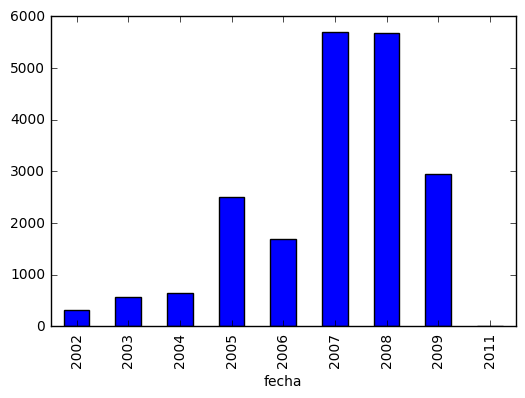

In [84]:

year = ci.groupby(ci.map(lambda x: x.year)).size()
print(year)
year.plot(kind='bar');

Existe un gran pico sobre los años 2007 y 2008, donde la cantidad de sentencias se dispara a mas del doble respecto a años anteriores. No se encontro ninguna explicacion para este comportamiento. Una hipótesis que podría explicar esto es el aumento en la digitalizacion de las sentencias, aunque no explicaria el decrecimiento posterior, y no tenemos elementos importantes que la sustenten.

importancia
ALTA     10063
BAJA      4206
MEDIA     5777
dtype: int64


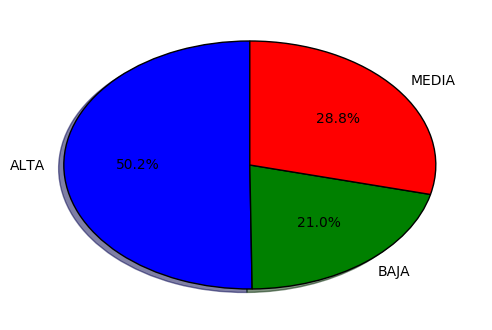

In [85]:
vi = corpus.groupby(['importancia']).size()
print(vi)
plt.pie(vi,labels=corpus['importancia'].unique(),autopct='%1.1f%%', shadow=True, startangle=90);

Las sentencias que integran el corpus pertenecen todas a Tribunales de Apelaciones y SCJ, con lo cual no resulta sorprendente que la mayoría de las sentencias sean de importancia alta, y la minoría baja. Esto se debe a que la mayoría de las sentencias ordinarias no llegan a estas instancias.

procedimiento
CAUSA DIPLOMATICA                                                     81
CONTIENDA DE COMPETENCIA                                             208
LESION DE AUTONOMIA                                                    6
OTROS                                                                620
PROCESO ADUANERO                                                      69
PROCESO ARBITRAL                                                       5
PROCESO CAUTELAR                                                     350
PROCESO CIVIL EXTRAORDINARIO                                        1046
PROCESO CIVIL ORDINARIO                                             7459
PROCESO CONCURSAL                                                     64
PROCESO DE AMPARO                                                    205
PROCESO DE EJECUCIÓN                                                 458
PROCESO DE INCONSTITUCIONALIDAD                                     1311
PROCESO INCIDENTAL                   

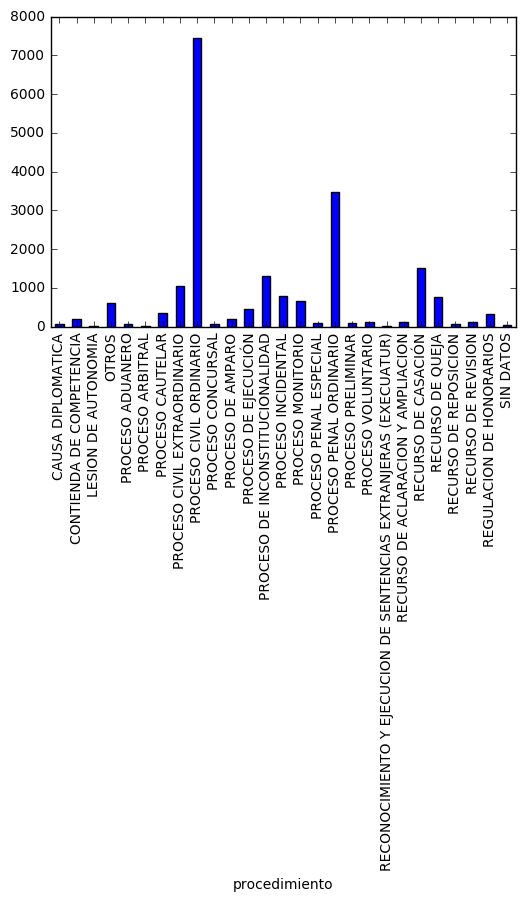

In [86]:
vi = corpus.groupby(['procedimiento']).size()
print(vi)
vi.plot(kind='bar');

[grafica por procedimiento]
El top tres de procedimientos está integrado por Proceso Civil ordinario seguido de Proceso Penal Ordinario y en tercer lugar Casaciones. 


sede
Suprema Corte de Justicia           3841
Tribunal Apelaciones Civil 1ºTº      971
Tribunal Apelaciones Civil 2ºTº      917
Tribunal Apelaciones Civil 3ºTº      924
Tribunal Apelaciones Civil 4ºTº     1381
Tribunal Apelaciones Civil 5ºTº      956
Tribunal Apelaciones Civil 6ºTº      950
Tribunal Apelaciones Civil 7ºTº     1168
Tribunal Apelaciones Familia 1ºT    1239
Tribunal Apelaciones Familia 2ºT     934
Tribunal Apelaciones Penal 1º Tº    1161
Tribunal Apelaciones Penal 2º Tº    1928
Tribunal Apelaciones Penal 3º Tº     445
Tribunal Apelaciones Trabajo 1ºT    1125
Tribunal Apelaciones Trabajo 2ºT     701
Tribunal Apelaciones Trabajo 3ºT    1405
dtype: int64


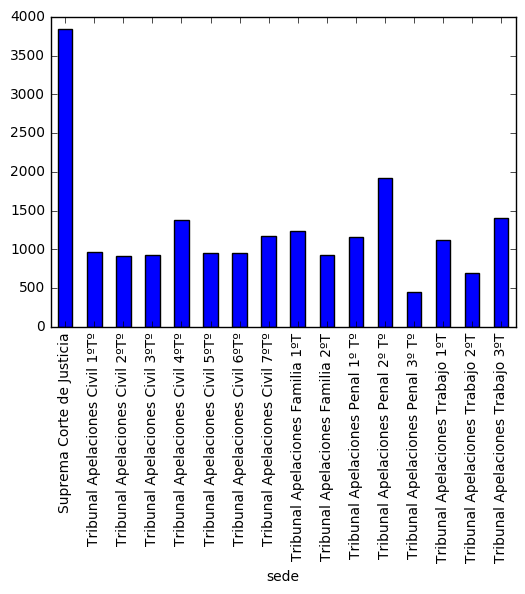

In [87]:
vi = corpus.groupby(['sede']).size()
print(vi)
vi.plot(kind='bar');

En cuanto al tipo de sentencia, el corpus discrimina entre aquellas que son definitivas y las interlocutorias, siendo las primeras las que ocurren en mas cantidad. Esto se debe en parte a que la mayoría de las sentencias interlocutorias, posteriormente reciben una definitiva, y que hay sanciones que son directamente definitivas sin pasar por las interlocutorias.

sede
Suprema Corte de Justicia           3841
Tribunal Apelaciones Civil 1ºTº      971
Tribunal Apelaciones Civil 2ºTº      917
Tribunal Apelaciones Civil 3ºTº      924
Tribunal Apelaciones Civil 4ºTº     1381
Tribunal Apelaciones Civil 5ºTº      956
Tribunal Apelaciones Civil 6ºTº      950
Tribunal Apelaciones Civil 7ºTº     1168
Tribunal Apelaciones Familia 1ºT    1239
Tribunal Apelaciones Familia 2ºT     934
Tribunal Apelaciones Penal 1º Tº    1161
Tribunal Apelaciones Penal 2º Tº    1928
Tribunal Apelaciones Penal 3º Tº     445
Tribunal Apelaciones Trabajo 1ºT    1125
Tribunal Apelaciones Trabajo 2ºT     701
Tribunal Apelaciones Trabajo 3ºT    1405
dtype: int64


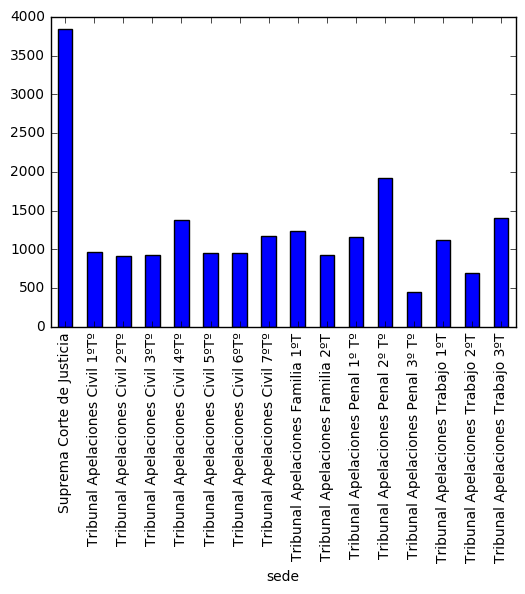

In [88]:
vi = corpus.groupby(['sede']).size()
print(vi)
vi.plot(kind='bar');

Claramente a nivel de sedes el que tiene más sentencias dictadas es la Suprema Corte de Justicia. Esto se explica porque por un lado, es unico en su tipo, a diferencia de los otros tribunales que tienen diversos turnos. Además, algunos casos no se terminan resolviendo en los tribunales de apelación y llegan hasta la Suprema Corte.

## Tokenización, separación en oraciones y tagging   
Comenzamos experimentando con expresiones regulares sencillas,  intentando tokenizar en base a reglas simples. Pronto notamos que tenia varios problemas a la hora de distinguir una oración de otra, por lo que volvimos a probar con NLTK. Vimos que pese a ser muy simple, logra reconocer cosas como oraciones que justo terminan en un acrónimo (como O.N.U.).
Luego, en un intento de obtener mejores resultados, decidimos pasarnos a freeling. Con el, ambas tareas (tokenizacion y etiquetado) al mismo tiempo, con lo que únicamente restaba hacer un mapeo entre los distintos conjuntos de etiquetas.

### Instalación de herramientas:
Nltk presenta una gran documentación y facilidad de uso. Su instalación fue inmediata, pero como se mencionó anteriormente, debido a sus resultados nos vimos obligados a buscar alternativas.
Freeling por otra parte, y como lo indica en su propia documentación “FreeLing is not a user-oriented text analysis tool. That is, it is not designed to be user friendly”, dió grandes problemas de instalación y uso.
Finalmente se utilizó una libreria llamada pyfreeling (https://github.com/malev/pyfreeling), para poder hacer uso del módulo Analizer de Freeling.Se modificarón archivos de pyfreeling (adjuntos en la entrega), para su compatibilidad con python >= 3.

#### Identificación de entidades con nombre.
Inicialmente este problema se encaró con dos herramientas diferentes: por un lado freeling, y por otro NLTK. El problema que plantea freeling es que al momento de reconocer una entidad que está compuesta por varias palabras, como ‘Facultad de Ingeniería’, concatena todas las palabras generando un único token ‘Facultad_de_Ingeniería’, violando el formato requerido. Este problema se puede evitar, si en vez de utilizar el Analyzer, se construye un programa específico para esta tarea, con freeling, dando el formato que se desee a la salida, y etiquetado individualmente cada una de las palabras  que componen la entidad (como en el ejemplo provisto en la letra para “Sra. Juez Letrado de Primera Instancia”). Se contempló la posibilidad de dejar de lado Analyzer y escribir un programa usando únicamente freeling, y pese a que se le dedicó tiempo, se abandonó esa idea por no llegar a resultados concretos.
Por otro lado, nltk provee un tokenizador y etiquetador muy simple de usar (comparativamente a nivel de usuario, todo es más simple de hacer con nltk). Dado que Freeling tiene mejores resultados tokenizando y taggeando  se optó por un enfoque híbrido.
Se toma el tag ‘form’ y el tag ‘ctag’ devuelto por el procesamiento con Freeling como entrada para el chunker de nltk.


#### Nltk_trainner 
[http://nltk-trainer.readthedocs.io/en/latest/] Es un conjunto de scripts python con los cuales se pueden realizar las tareas:
        <ol>
        <li>Train NLTK based models.</li>
        <li>Evaluate pickled models against a corpus.</li>
        <li>Analyze a corpus.</li>
        </ol>


#### Corpus Conll2002
Es un corpus integrado en NLTK que está disponible en el idioma español.
Se encuentra taggeado y con reconocimiento de entidades.


Mediante Nltk_trainner se entrenó un chunker usando Naive bayes sobre el corpus Conll2002.


*python train_chunker.py conll2002 --fileids esp.train --classifier NaiveBayes --filename naiveBayes.pickle *


Finalmente se aplica un conversor para pasar a formato IOB.



In [89]:
import sys
#ruta a la carpeta de nltk_trainner
sys.path.append('./nltk-trainer-master')

#se importa el tagger y chunker ya entrenados con nltk trainner
tagger = nltk.data.load('taggers.pickle')
chunker = nltk.data.load('naiveBayes.pickle')

## Conversión a universal postag
El formato devuelto por Freeling es conll, y el campo tag y feats debió ser convertido a Universal Pos Tag. Para esta tarea se encontraron dos formas de lograrlo.
Una es editar directamente el archivo tagset.dat dentro de la carpeta de configuración Freeling y cambiando al formato deseado.
La otra opción, que fue la elegida, es usar una tabla de conversión a universal pos tag. La tabla cuenta con aproximadamente 270 entradas [http://universaldependencies.org/tagset-conversion/es-conll2009-uposf.html]. Se  construyó un programa en python que implementa esta conversión.


### Problemas encontrados:
La conversión a universal postag no es directa. Hay campos que no se utilizan en postag, por ejemplo en las Noun los campos neclass, nesubclass y degree no son utilizados.
Por otro lado, universal pos tag tiene campos que no es posible construirlos con la información disponible en el formato actual.


In [90]:
config_file = 'es.cfg'
analyzer = Analyzer(config=config_file)

In [91]:
def tag_it_all(text):
    o = analyzer.run(text.encode('utf-8'),'flush','noner','nortkcon', output='json', lang='es').decode("utf-8")
    return json.loads("[" + o + "]")
# TODO: No esta muy prolijo usar en analyzer global, habria que pasarlo como parametro

In [92]:
#recibe una sentencia y retorna una lista en formato [(form,ctag),...]
def prepare_list_sentence_for_ner(sentence):
    resultado = []
    for word in sentence:
        if '+' in word['ctag']:
            splitCtag = word['ctag'].split('+') 
            splitLemma = word['lemma'].split('+') 
            for i in range(len(splitCtag)):
                resultado.append((splitLemma[i],splitCtag[i]))
        else:
            resultado.append((word['form'],word['ctag']))
    return resultado

In [93]:
#recibe una lista de tuplas [(form,ctag)]
#retorna una lista con el tag ner en formato IOB
def list_to_ner(lista_entrada):
    #se calcula el ner
    str_chunks = chunker.parse(lista_entrada)
    #se convierte a formato IOB
    newList = nltk.chunk.tree2conlltags(str_chunks)
    #se eliminan los campos MISC
    list_of_ners = [list(elem) for elem in newList]
    for i in list_of_ners:
        if 'MISC' in i[2]:
            i[2]='O'
    return list_of_ners

In [94]:
def json_to_string(lista_entrada):
    ret = ""
    for sent_id, entrada in enumerate(lista_entrada):
        list_tags = prepare_list_sentence_for_ner(entrada['tokens'])
        ner_list = list_to_ner(list_tags)
        nerCounter = 0
        offset = 1
        for token_id, token in enumerate(entrada['tokens']):
            form = token['form']
            if token['tag'].count('+') > 0:
                #Estamos en una contraccion
                tags = token['tag'].split('+')
                lemmas = token['lemma'].split('+')
                ret += str(token_id+1) + "-"
                sub_ret = "\t" + form + '\t_\t_\t_\t_\t_\t_\t_\t_\n'
                offset += len(tags)-1
                for i in range(len(tags)):
                    lemma = lemmas[i]
                    l = list(tags[i])
                    nuestro = up.upos_converter(l)
                    upostag, feats = up.upos_converter(l)
                    pos=token_id + i+1
                    sub_ret += str(pos) + '\t' + lemma  + '\t' + lemma + '\t' + upostag + '\t' + feats + '\t_\t_\t_\t_\t' + ner_list[nerCounter][2] +'\n'
                    nerCounter=nerCounter+1
                #Fin del for, concatenamos el sub resultado
                ret += str(token_id + len(tags))+sub_ret
            else:   
                lemma = token['lemma']
                l = list(token['tag'])
                nuestro = up.upos_converter(l)
                upostag, feats = up.upos_converter(l)
                pos=token_id + offset
                ret += str(pos) + '\t' + form  + '\t' + lemma + '\t' + upostag + '\t' + feats + '\t_\t_\t_\t_\t' +  ner_list[nerCounter][2] +'\n'
                nerCounter=nerCounter+1
        ret += '\n'
    return ret

In [95]:
print(json_to_string(tag_it_all("Pedro es el perro del Juan, Antonio es malo. Queda poco tiempo...")))

1	Pedro	pedro	NOUN	Gender=Masc|Number=Sing	_	_	_	_	B-PER
2	es	ser	VERB	Mood=Ind|Number=Sing|Person=3|Tense=Pres	_	_	_	_	O
3	el	el	DET	Gender=Masc|Number=Sing|PronType=Art	_	_	_	_	O
4	perro	perro	NOUN	Gender=Masc|Number=Sing	_	_	_	_	B-ORG
5-6	del	_	_	_	_	_	_	_	_
5	de	de	ADP		_	_	_	_	O
6	el	el	DET	Gender=Masc|Number=Sing|PronType=Art	_	_	_	_	O
7	Juan	juan	NOUN	Gender=Masc|Number=Sing	_	_	_	_	B-ORG
8	,	,	PUNCT		_	_	_	_	O
9	Antonio	antonio	NOUN	Gender=Masc|Number=Sing	_	_	_	_	B-PER
10	es	ser	VERB	Mood=Ind|Number=Sing|Person=3|Tense=Pres	_	_	_	_	O
11	malo	malo	ADJ	Gender=Masc|Number=Sing	_	_	_	_	O
12	.	.	PUNCT		_	_	_	_	O

1	Queda	quedar	VERB	Mood=Ind|Number=Sing|Person=3|Tense=Pres	_	_	_	_	O
2	poco	poco	DET	Gender=Masc|Number=Sing|PronType=Ind	_	_	_	_	O
3	tiempo	tiempo	NOUN	Gender=Masc|Number=Sing	_	_	_	_	O
4	...	...	PUNCT		_	_	_	_	O




In [96]:
corpus = pandas.read_csv("corpus_pj.csv", delimiter=',', skip_blank_lines=True, encoding='utf-8')
corpus = corpus.drop_duplicates()
sentencias = corpus["sentencia"]

In [97]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Procedimiento para seleccion y muestra interactiva

El procedimiento show muestra en la salida estándar, con el formato ConLL-U especificado en letra, el etiquetado de una sentencia. Para esto, espera recibir un entero indicando cual de las 20.046 sentencias disponibles. En caso de que el entero no esté en el rango 0-20045, se aplica la operación módulo para asegurar su correcto funcionamiento. En caso de no ingresar ningún parámetro, se elige una sentencia completamente al azar. Opcionalmente se lo puede invocar directamente con una o varias oraciones a ser analizadas. Esto último resulta extremadamente útil durante el desarrollo.

In [98]:
importlib.reload(up)
def show(sentencia=None):
    if type(sentencia) == str:
        texto = sentencia
    else:
        if type(sentencia) == int:
            i = sentencia % len(sentencias)
        else:
            i = random.randrange(len(sentencias))
            print(i)
        texto = sentencias[i]
    try:
        text=json_to_string(tag_it_all(texto))
        #print(text)
        for line in text.split("\n"):
            line = line.split("\t")# Splits on whitespace
            if len(line)==10:
                print('{0[0]:<10}{0[1]:<35}{0[2]:<25}{0[3]:<10}{0[4]:>55}{0[5]:>2}{0[6]:>2}{0[7]:>2}{0[8]:>2}{0[9]:>7}'.format(line))
            else:
                print(line[0])
    except Exception as e:
        print(i)
        raise e

In [99]:
show("Mi mamá me mima.")

1         Mi                                 mi                       DET                                          Number=Sing|Person=1 _ _ _ _      O
2         mamá                               mamá                     NOUN                                       Gender=Fem|Number=Sing _ _ _ _      O
3         me                                 me                       PRON                            Number=Sing|Person=1|PronType=Prs _ _ _ _      O
4         mima                               mimar                    VERB                     Mood=Ind|Number=Sing|Person=3|Tense=Pres _ _ _ _      O
5         .                                  .                        PUNCT                                                             _ _ _ _      O




## Metodología de evaluación: técnicas y medidas.
Es fundamental tener al menos un conjunto de evaluacion etiquetado con el que compararse. Luego nos va a importar la relación que existe entre los que están bien etiquetados y los que no, que se puede extraer basado en la matriz de confusión y utilizar varios criterios para determinar que tan bien se desarrolló la tarea, como precision, recall o medida F. Este enfoque funciona bien para evaluar el lemma y el U-postag, dado que para cada token corresponde un único lema y U-postag: sabemos que un lema o etiqueta es correcto cuando son exactamente iguales al de testeo. Sin embargo, esto no es necesariamente así a la hora de comparar las feats o las entidades. Por un lado, las feats agrupan múltiples características para un mismo token, por lo que si el anotador es capaz de etiquetar algunas bien y otras mal, podría ser útil una noción de bien y mal para el token que sea algo más laxa, como admitir como correctas las características que difieran en a lo sumo una característica. Por otro lado, cuando nos enfrentamos a  la tarea de NER con el formato IOB, la dificultad radica en que es una tarea secuencial: un error al comienzo de la secuencia se va a arrastrar durante toda la misma. Para comparar dos algoritmos, si uno detecta una entidad por la mitad (por ejemplo, Facultad en Facultad de Ingeniería), y el otro no detecta nada, deberíamos tomar algún criterio de evaluación que refleje la diferencia entre ellos. Una vez más, podemos aceptar como correctas las etiquetas que difieren en a lo sumo un token respecto de la referencia.
Una carencia que tiene este enfoque tal cual esta planteado, tanto para NER como para las características, es que no toma en cuenta la cantidad de tokens en la entidad o de características en el token: una entidad que tenga un único token y sea mal etiquetada, como difiere en a lo sumo un token, durante la evaluación va a ser considerada como correcta, lo cual es completamente erróneo: este enfoque es demasiado permisivo. Para corregirlo, se debe considerar el largo de la secuencia, o la cantidad de  características, y por ejemplo, admitir como correcta si hay una en tres mal, o una en cinco mal.
Con esto estamos agregando dos parámetros de manera arbitraria, a nuestra evaluación, que van a cambiar drásticamente el resultado. 

## Análisis cualitativo de los resultados obtenidos y principales desafíos a futuro.


De las primeras cosas a notar es que es muy malo reconociendo oraciones. A modo de ejemplo, en la sentencia 3844 se reconocen únicamente tres oraciones en toda la sentencia, siendo la última la más larga: desde el token 432 al 1417.


Por otro lado, se hicieron una serie de pruebas con oraciones simples que si bien no son ambiguas, contienen palabras que a veces están como verbo y otras como sustantivo. Si bien fue un conjunto reducido, se puede ver que la mayoría de las veces lo resuelve de forma correcta. Los casos en los que falla son aquellos en los que el contexto es muy pobre (sal de ahí) o el uso de la palabra es muy local (no te banco más).


Para chequear empíricamente la hipótesis del contexto, se intentó re etiquetar las mismas frases, provistas de más contexto para ver si el resultado cambiaba, pero fue el mismo.


Como principal desafío a futuro esta obtener resultados cuantitativos, donde se pueda medir que tan bien funciona el tagger propuesto y compararlo con otros existentes. Para esto es imprescindible contar con un corpus etiquetado en el mismo formato.


El corpus etiquetado está disponible en [https://drive.google.com/file/d/0B_jlf-PvSRYbeFd5cW90NGNQdW8/view]. Debido al peso y horas de computo necesarias, se entregan aproximadamente 2000 sentencias procesadas. Se deja la funcion usada para generar el corpus etiquetado.


In [100]:
show("Elsa llama a la llama.") 

1         Elsa                               elsa                     NOUN                                       Gender=Fem|Number=Sing _ _ _ _  B-PER
2         llama                              llamar                   VERB                     Mood=Ind|Number=Sing|Person=3|Tense=Pres _ _ _ _      O
3         a                                  a                        ADP                                                               _ _ _ _      O
4         la                                 el                       DET                           Gender=Fem|Number=Sing|PronType=Art _ _ _ _      O
5         llama                              llama                    NOUN                                       Gender=Fem|Number=Sing _ _ _ _  B-ORG
6         .                                  .                        PUNCT                                                             _ _ _ _      O




In [101]:
show("No te banco más.")# Pone banco como noun

1         No                                 no                       ADV                                                  Negative=Neg _ _ _ _      O
2         te                                 te                       PRON                            Number=Sing|Person=2|PronType=Prs _ _ _ _      O
3         banco                              banco                    NOUN                                      Gender=Masc|Number=Sing _ _ _ _      O
4         más                                más                      ADV                                                               _ _ _ _      O
5         .                                  .                        PUNCT                                                             _ _ _ _      O




In [102]:
show("Ese número no lleva coma.")


1         Ese                                ese                      DET                          Gender=Masc|Number=Sing|PronType=Dem _ _ _ _      O
2         número                             número                   NOUN                                      Gender=Masc|Number=Sing _ _ _ _      O
3         no                                 no                       ADV                                                  Negative=Neg _ _ _ _      O
4         lleva                              llevar                   VERB                     Mood=Ind|Number=Sing|Person=3|Tense=Pres _ _ _ _      O
5         coma                               coma                     NOUN                                                  Number=Sing _ _ _ _      O
6         .                                  .                        PUNCT                                                             _ _ _ _      O




In [77]:
show("Deja la comida que sobre sobre la mesa de la cocina, dijo llevando el sobre en la mano") #el primer sobre es un verbo?

Object `verbo` not found.


In [ ]:
show("Sal de ahí.")

In [ ]:
show("Hoy alcé un alce.")

In [ ]:
show("Alce un alce.")

In [ ]:
show("Amo a mi amo.")

In [ ]:
show("El bota la pelota con la bota.")

In [ ]:
show("La abuela le dijo: \"sal de ahí que te vas a caer\".")

In [ ]:
show("Me tenes cansada, no te banco más, siempre lo mismo.")

In [ ]:
def etiquetar_sentencia(sentencia=None):
    if type(sentencia) == str:
        texto = sentencia
    else:
        if type(sentencia) == int:
            i = sentencia % len(sentencias)
        else:
            i = random.randrange(len(sentencias))
            print(i)
        texto = sentencias[i]
    try:
        text=json_to_string(tag_it_all(texto))
        return text
    except Exception as e:
        print(i)
        raise e




In [ ]:
def generar_corpus_etiquetado():
    for i in range(0,len(sentencias)):
        try:
            sent = etiquetar_sentencia(i)
            with open("corpus_grupo_3.txt", "a") as myfile:
                myfile.write(sent)
        except Exception as e:
            continue

In [ ]:
# generar_corpus_etiquetado()